In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [5]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


I want to conduct some EDA to get better than the original default random forest model that the starter code gave me.

In [6]:
train_data["Pclass"].unique()
# so 3 classes, want to verify proportion of each class that survived

array([3, 1, 2])

In [7]:
survived_class1 = train_data.loc[train_data.Pclass == 1]["Survived"] 
survived_class2 = train_data.loc[train_data.Pclass == 2]["Survived"]
survived_class3 = train_data.loc[train_data.Pclass == 3]["Survived"]

prop_survived_class1 = sum(survived_class1) / len(survived_class1)
prop_survived_class2 = sum(survived_class2) / len(survived_class2)
prop_survived_class3 = sum(survived_class3) / len(survived_class3)

print(f"% of each class survived from Class 1 to Class 3: {prop_survived_class1}, {prop_survived_class2}, {prop_survived_class3}")

% of each class survived from Class 1 to Class 3: 0.6296296296296297, 0.47282608695652173, 0.24236252545824846


So it seems like there is some relationship between surviving and which class you were. Makes sense logically as lower classes were on lower decks, so harder to get to the surface. 
I now want to explore the EDA for children, want to see proportion of 0 to 10, 0 to 16, and 0 to 18 years old. I probably want a histogram overall first. 

Text(0, 0.5, 'Freq')

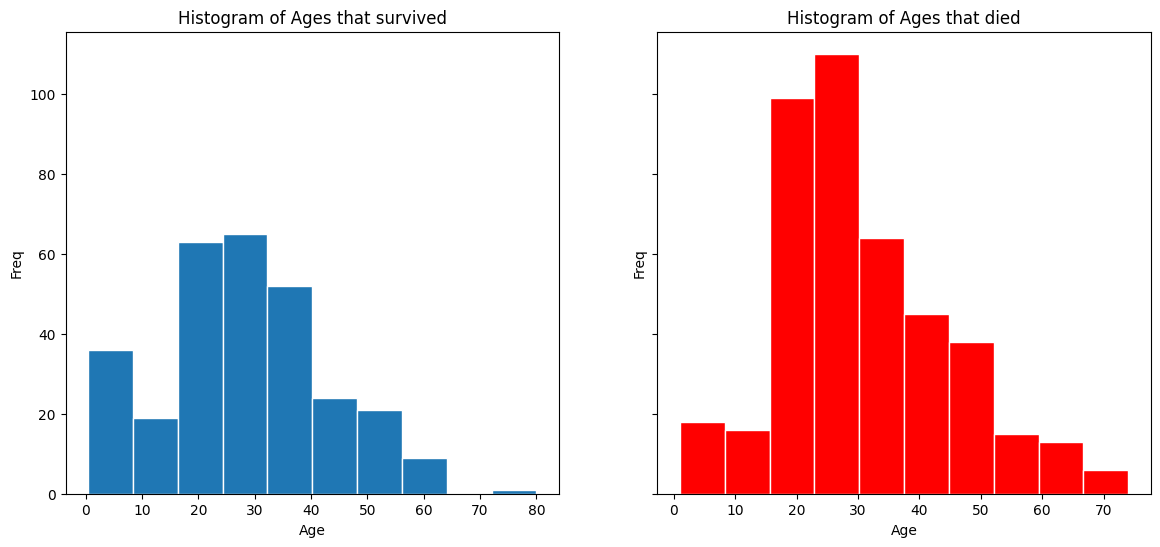

In [8]:
import matplotlib.pyplot as plt
age_of_survivors = train_data.loc[train_data["Survived"] == 1, "Age"]
age_of_died = train_data.loc[train_data["Survived"] == 0, "Age"]

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (14,6), sharey = True)

axes[0].hist(age_of_survivors, edgecolor = "white")
axes[0].set_title("Histogram of Ages that survived")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Freq")

axes[1].hist(age_of_died, edgecolor = "white", color = "red")
axes[1].set_title("Histogram of Ages that died")
axes[1].set_xlabel("Age")
axes[1].set_ylabel("Freq")


It does seem like from ages up to around 9 there are twice more that survived than died. All the other ages there are more people who died than survived. So, I suppose I can use Ages less or equal than 9 to have a higher chance of survival on the model. 

Ok I want to conduct two last EDA and that is with the Parch and Sibsp columns. I want to see if having a family increased the rate of survival, especially e.x say you are a younger sister (based on the previous eda collected you are more likely to survive). I want to see if this is true. 

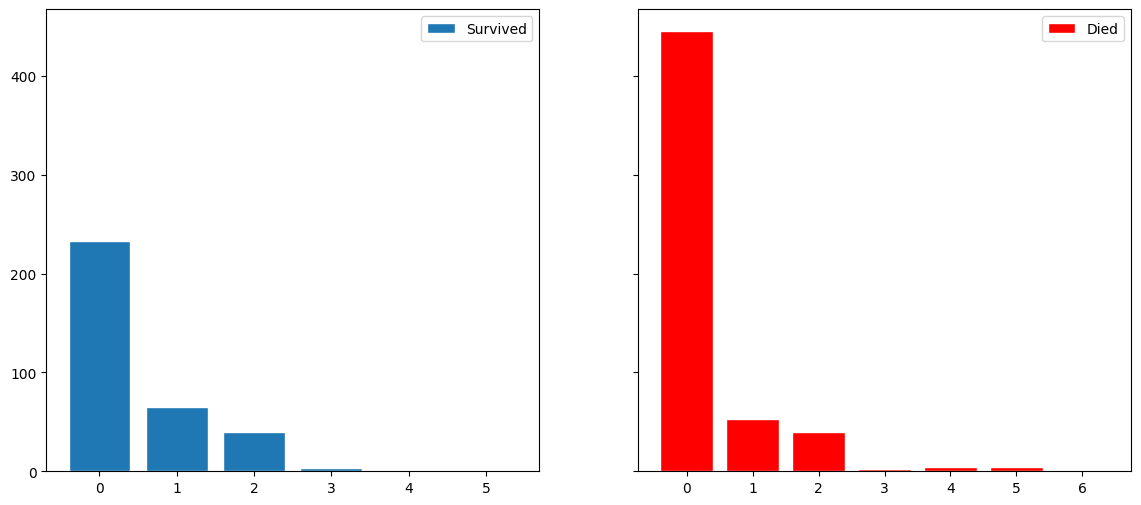

In [9]:
parch_survived = train_data.loc[train_data["Survived"] == 1, "Parch"]
parch_died = train_data.loc[train_data["Survived"] == 0, "Parch"]

parch_survived = parch_survived.value_counts()
x_1 = parch_survived.sort_index().index
y_1 = parch_survived.sort_index().values

parch_died = parch_died.value_counts()
x_2 = parch_died.sort_index().index
y_2 = parch_died.sort_index().values

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6), sharey = True)

axes[0].bar(x_1, y_1, edgecolor = "white", label = "Survived")
axes[1].bar(x_2, y_2, color = "red", edgecolor = "white", label = "Died")

axes[0].legend()
axes[1].legend()

plt.show()

For me, it doesn't seem like there is a good indicator that having # parents/children is helpful to model.